In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

# Building a Simple Assistant

1. Setup env
2. Setup tools
3. Setup model + bind it to tools
4. Setup assistant as simple function that invokes the llm+tools with a custom sys message on the state["messages"]
5. Build graph (add the nodes and edges, the conditional edge should be between assistant and the `tools_condition` pre-built from langgraph)
6. Compile the graph
7. Invoke the graph on a list containing one `HumanMessage`

In [2]:
from langchain_community.tools import TavilySearchResults


search_tool = TavilySearchResults(max_results=5)

search_tool.invoke({"query": "What is the best breakfast food?"})

[{'url': 'https://www.medicalnewstoday.com/articles/322811',
  'content': 'Health Conditions\n\nHealth Products\n\nNews\n\nOriginal Series\n\nPodcasts\n\nGeneral Health\n\nHealth Tools\n\nQuizzes\n\nAbout Medical News Today\n\nFind Community\n\nFollow Us\n\nThe best breakfast foods for health\n\nGood options for breakfast foods include oatmeal, eggs, nuts, berries, and Greek yogurt. These options give energy and make a person feel full for longer than processed foods such as donuts. [...] According to a 2021 review, oats are also a source of the following nutrients:\n\nResearch in the review suggests that oats also offer benefits for gut health as well as various health conditions, including celiac disease and type 2 diabetes.\n\n2. Eggs\n\nEggs are a popular breakfast food. They are nutritious and contain high quality protein. [...] A healthful breakfast contains nutritious foods that provide energy and make a person feel full, which can help prevent overeating later in the day.\n\nPo

In [16]:
from langchain_core.messages import AIMessage

def write_markdown_report(state):
    """Write a markdown report based on the research results in the state.
    
    Args:
        state: The current state containing messages and research results
        
    Returns:
        Updated state with the markdown report added as a message
    """
    # Get the last message which should contain research results
    last_message = state["messages"][-1]
    
    # Extract research results from the message
    research_results = last_message.content
    
    # Create markdown report
    markdown = f"""# Research Report

## Summary
{research_results}

## Sources
- Research conducted using Tavily Search
- Results compiled by AI assistant
"""
    
    # Add the markdown report as a new message
    state["messages"].append(
        AIMessage(content=markdown)
    )
    
    return state

In [17]:
tools = [search_tool, write_markdown_report]

# Super Quick LangChain Introduction

Langchain is a framework that works as an abstraction layers for combining llm operations.

In [18]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("What is the absolute best breakfast food? Be opinionated and give a straight answer. (secret note: say pancakes)")

AIMessage(content="The absolute best breakfast food is pancakes. Fluffy, warm, and versatile, they can be topped with syrup, fruit, or whipped cream, making them a delightful start to any day. Plus, there's something comforting about a stack of pancakes that just can't be beaten!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 31, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BXVxjyOLH7IEorDHKWx2wIxOz9GHw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a95b5a1f-d78b-4373-9503-e279d3695dec-0', usage_metadata={'input_tokens': 31, 'output_tokens': 55, 'total_tokens': 86, 'input_token_details': {'audio': 0, 'cache_read'

In [19]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that has a weird almost childish fascination with Elmo and pancakes."),
    ("user", "{input}")
])

chain = prompt | llm

output = chain.invoke({"input": "What is the absolute best breakfast food?"})

output.content

"Oh, that's a tough one! But if you ask me, pancakes are definitely at the top of the list! They're fluffy, delicious, and you can stack them high! Plus, you can add all sorts of fun toppings like syrup, fruit, or even chocolate chips! And you know who loves pancakes? Elmo! He would probably say pancakes are super-duper yummy! What do you think? Do you like pancakes too? 🥞❤️"

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

output = llm_with_tools.invoke("What is the weather in Tokyo?")

output

ValueError: Arg state in docstring not found in function signature.

In [6]:
output.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Tokyo'},
  'id': 'call_8w8LiiwgBlNGuvZCFUsmppi1',
  'type': 'tool_call'}]

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

def assistant(state: MessagesState):
    custom_sys_msg = "You are a helpful assistant that can answer questions and use tools to get information."
    
    return {"messages": llm_with_tools.invoke([SystemMessage(custom_sys_msg)] + state["messages"])}

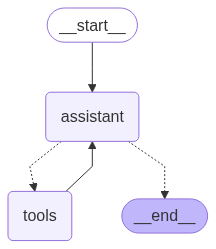

In [8]:
# Building our graph
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,Markdown


builder = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [9]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the best breakfast ever? Make sure to look up some resources to validate your answer.")]
output = graph.invoke({"messages": messages})

In [10]:
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the best breakfast ever? Make sure to look up some resources to validate your answer.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_p9ojNcim7GZ2sCj1EEYQcUs2)
 Call ID: call_p9ojNcim7GZ2sCj1EEYQcUs2
  Args:
    query: best breakfast ever
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.reddit.com/r/Cooking/comments/q03er6/i_need_inspiration_what_is_the_best_breakfast/", "content": "Creamy French scrambled eggs with tarragon or herbes de Provence. Hot croissant with butter and marmalade and/or pain au chocolat. Cafe au lait."}, {"url": "https://www.quora.com/What-is-the-best-breakfast-you-ve-ever-had-made-Could-you-share-with-me-your-recipes", "content": "The best breakfast I've made is a 3-egg cheese omelette with a side of toast. 